# 1. 模型选择

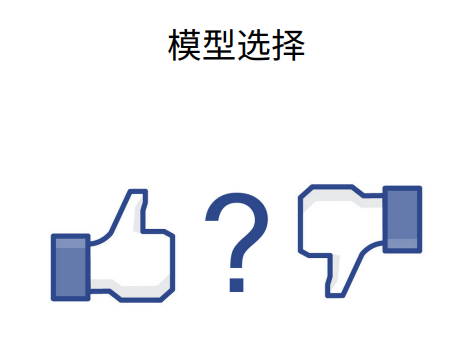

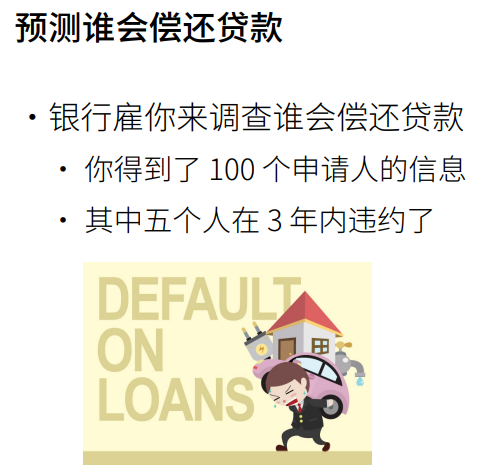

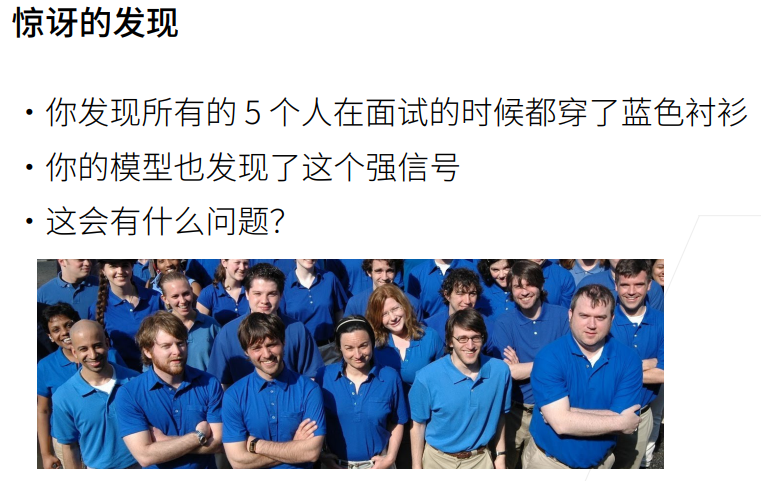

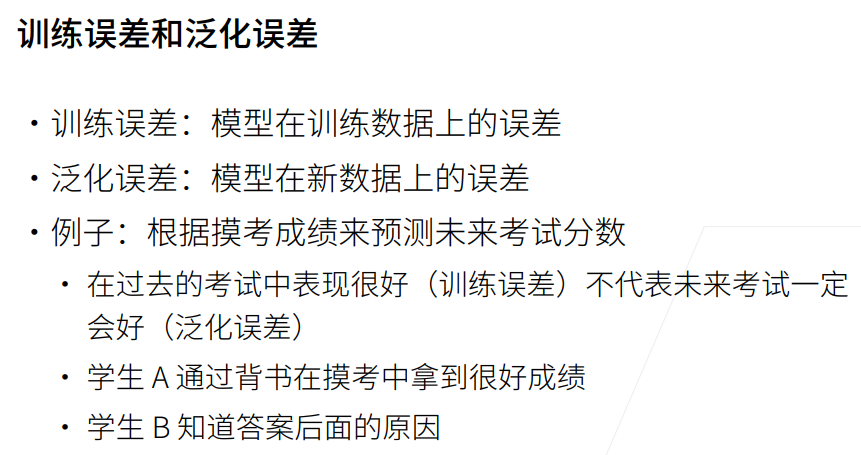

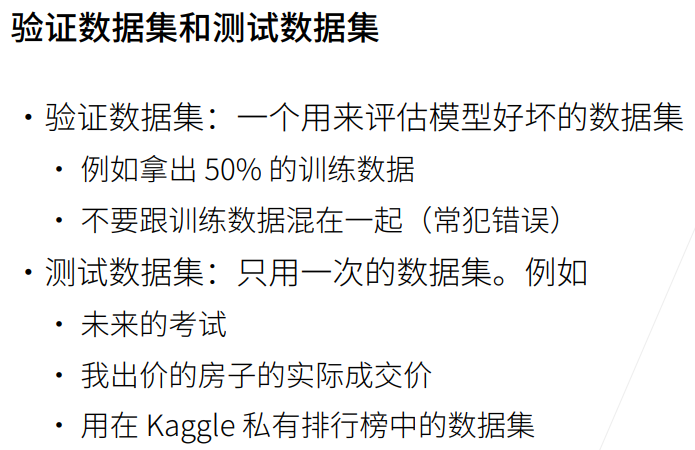

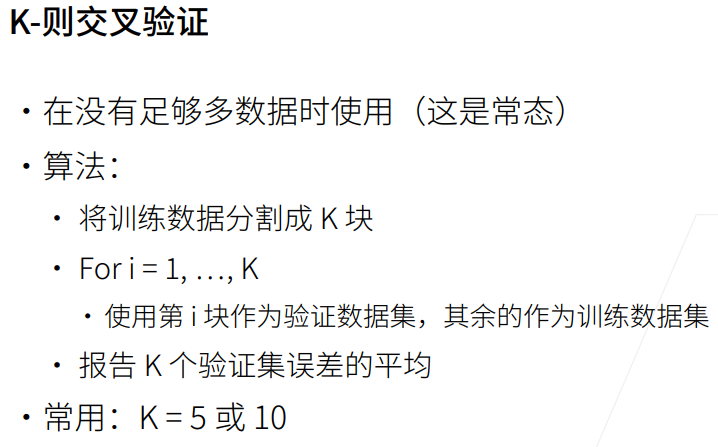

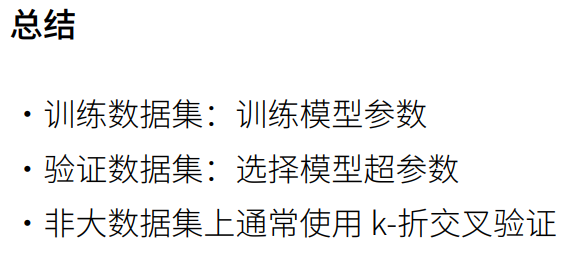

# 2. 过拟合、欠拟合

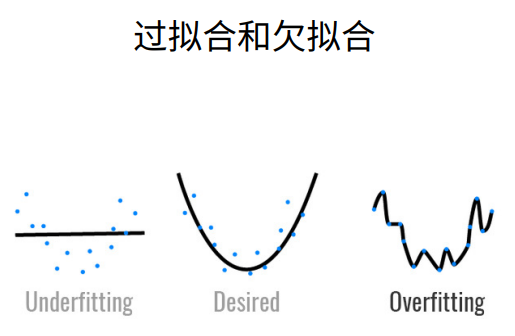

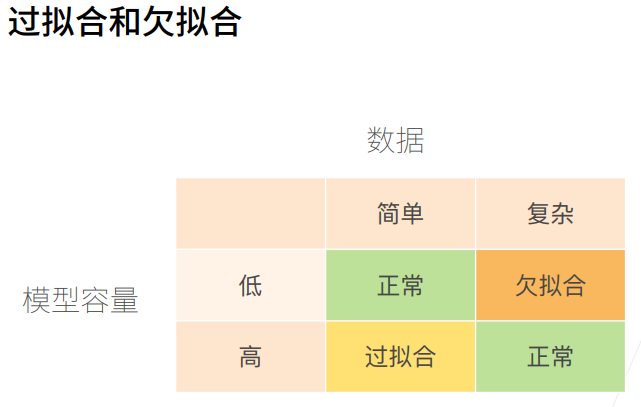

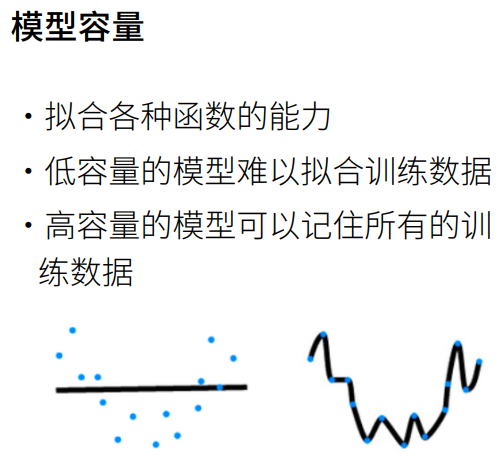

① 在多项式拟合中，模型容量为不同多项式次方。

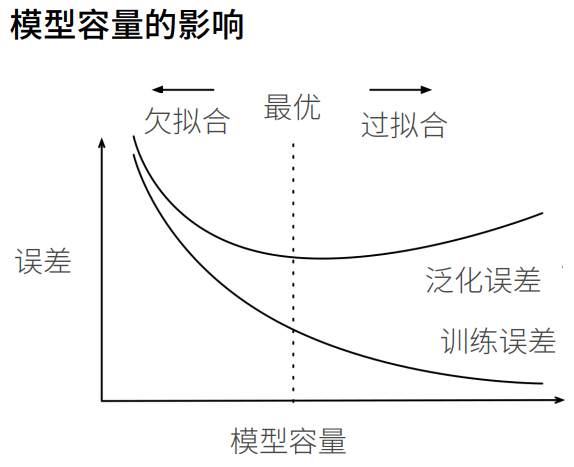

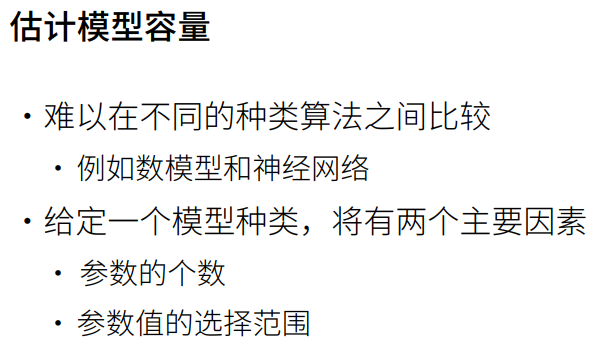

② d是特征向量的维度，1是偏置b的维度。

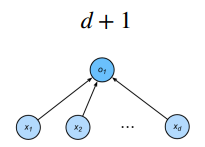

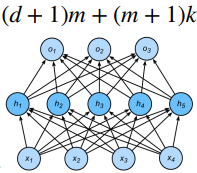

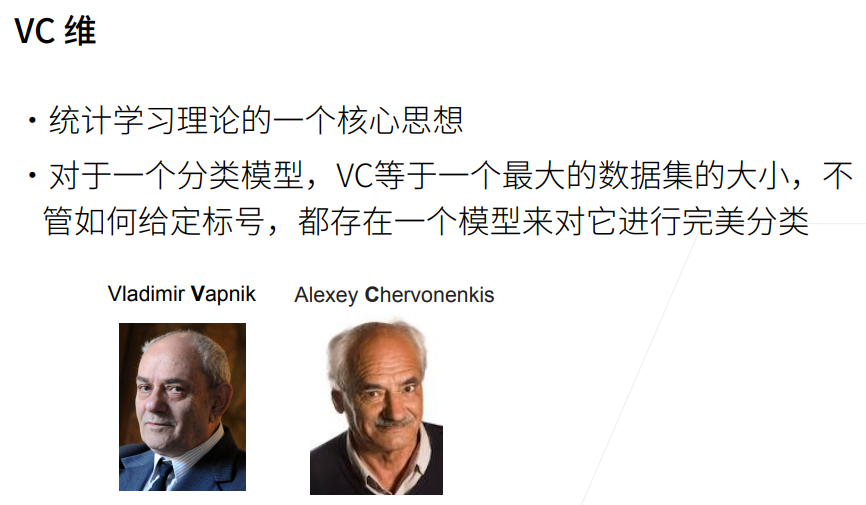

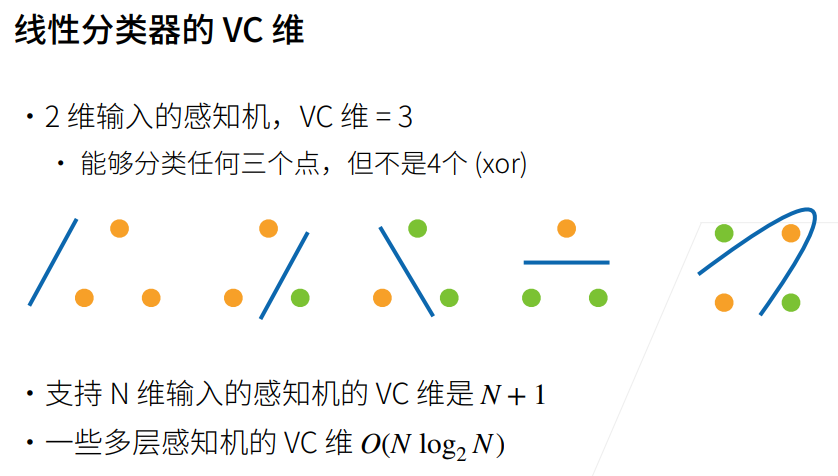

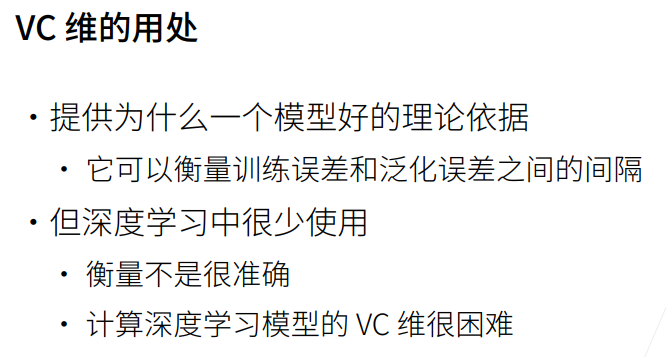

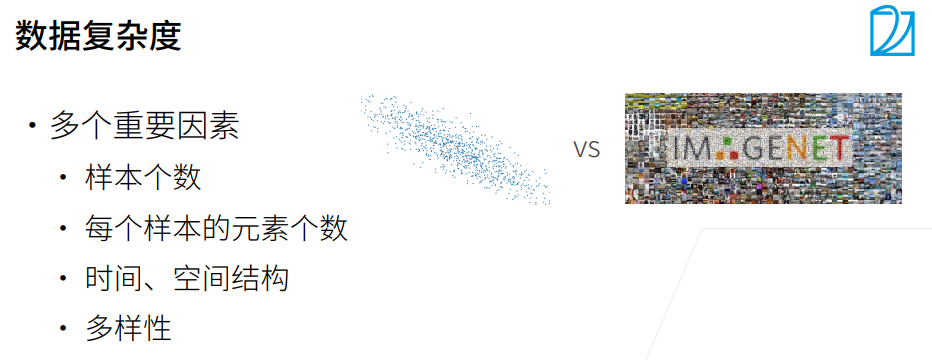

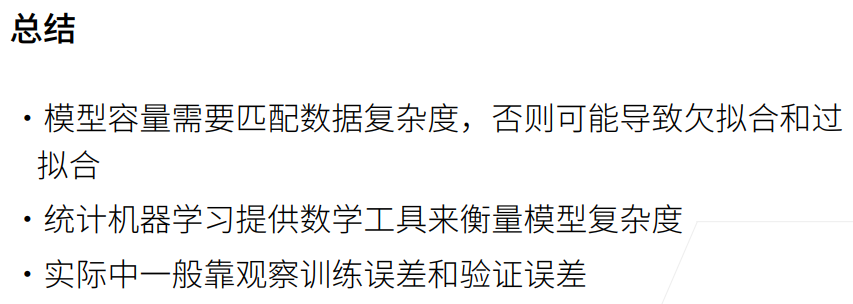

# 3. 多项式解释欠拟合、过拟合

① 使用以下三阶多项式来生成训练和测试数据的标签：$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

② 这个式子只是一个三次多项式，并不是哪个函数的泰勒展开。

In [1]:
# 通过多项式拟合来交互地探索这些概念
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

max_degree = 20 # 特征为20就是每一个样本是一个[20,1]的tensor
n_train, n_test = 100, 100 # 100个测试样本、100验证样本
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6]) # 真实标号为5

features = np.random.normal(size=(n_train+n_test,1))
print(features.shape)
np.random.shuffle(features)
print(np.arange(max_degree))
print(np.arange(max_degree).reshape(1,-1))
print(np.power([[10,20]],[[1,2]]))
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1)) # 对第所有维的特征取0次方、1次方、2次方...19次方  
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # i次方的特征除以(i+1)阶乘
labels = np.dot(poly_features,true_w) # 根据多项式生成y，即生成真实的labels
labels += np.random.normal(scale=0.1,size=labels.shape) # 对真实labels加噪音进去

#看一下前两个样本
true_w, features, poly_features, labels = [torch.tensor(x,dtype=torch.float32) for x in [true_w, features, poly_features, labels]]                 
print(features[:2]) # 前两个样本的x
print(poly_features[:2,:]) # 前两个样本的x的所有次方
print(labels[:2])  # 前两个样本的x对应的y

# 实现一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 两个数的累加器
    for X, y in data_iter: # 从迭代器中拿出对应特征和标签
        out = net(X)
        y = y.reshape(out.shape) # 将真实标签改为网络输出标签的形式，统一形式
        l = loss(out, y) # 计算网络输出的预测值与真实值之间的损失差值
        metric.add(l.sum(), l.numel()) # 总量除以个数，等于平均
    return metric[0] / metric[1] # 返回数据集的平均损失

# 定义训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) # 单层线性回归
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)    
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])                   
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net,test_iter,loss)))
    print('weight',net[0].weight.data.numpy()) # 训练完后打印，打印最终学到的weight值  

(200, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
[[ 10 400]]
tensor([[-0.9840],
        [ 1.2229]])
tensor([[ 1.0000e+00, -9.8401e-01,  4.8414e-01, -1.5880e-01,  3.9065e-02,
         -7.6880e-03,  1.2608e-03, -1.7724e-04,  2.1801e-05, -2.3836e-06,
          2.3455e-07, -2.0981e-08,  1.7205e-09, -1.3023e-10,  9.1534e-12,
         -6.0047e-13,  3.6929e-14, -2.1376e-15,  1.1685e-16, -6.0519e-18],
        [ 1.0000e+00,  1.2229e+00,  7.4775e-01,  3.0481e-01,  9.3187e-02,
          2.2792e-02,  4.6454e-03,  8.1155e-04,  1.2406e-04,  1.6856e-05,
          2.0614e-06,  2.2917e-07,  2.3354e-08,  2.1969e-09,  1.9190e-10,
          1.5645e-11,  1.1958e-12,  8.6019e-14,  5.8441e-15,  3.7614e-16]])
tensor([1.1747, 5.7716])


weight [[ 4.988501   1.2836959 -3.3589993  5.405713 ]]


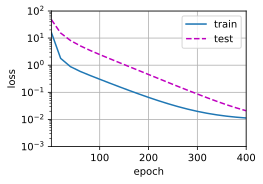

In [2]:
# 三阶多项式函数拟合(正态)
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])  # 最后返回的weight值和公式真实weight值很接近       

weight [[3.6593914 3.0195978]]


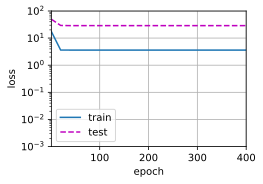

In [3]:
# 一阶多项式函数拟合(欠拟合)
# 这里相当于用一阶多项式拟合真实的三阶多项式，欠拟合了，损失很高，根本就没降
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])

weight [[ 4.95713     1.2931961  -3.142203    5.1588063  -0.683433    1.3676366
  -0.22168443  0.30410182  0.22201246 -0.01267278 -0.06214145 -0.1347487
  -0.16502385 -0.16112421 -0.10519557 -0.06851828  0.03842303  0.07775125
   0.12161571 -0.05093227]]


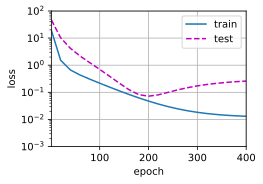

In [4]:
# 十九阶多项式函数拟合(过拟合)
# 这里相当于用十九阶多项式拟合真实的三阶多项式，过拟合了
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])